In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
from scipy import stats

No handles with labels found to put in legend.


,patient,day,response,dose,therapeutic_range,Effect of CURATE.AI-assisted dosing,Dose range
0,1,2,2.4,0.051546,non_therapeutic,"Unaffected, remain as non-therapeutic range",Low
1,1,3,2.8,0.103093,non_therapeutic,"Unaffected, remain as non-therapeutic range",Low
2,1,4,3.2,0.154639,non_therapeutic,Improve to therapeutic range,Low
3,1,5,3.1,0.154639,non_therapeutic,Improve to therapeutic range,Low
4,1,6,7.9,0.309278,non_therapeutic,"Unaffected, remain as non-therapeutic range",Medium
...,...,...,...,...,...,...,...
274,16,18,5.5,0.108401,non_therapeutic,Improve to therapeutic range,Low
275,16,19,8.8,0.135501,therapeutic,Worsen to non-therapeutic range,Low
276,16,21,6.8,0.000000,non_therapeutic,"Unaffected, remain as non-therapeutic range",Low
277,16,22,9.3,0.000000,therapeutic,"Unaffected, remain as therapeutic range",Low


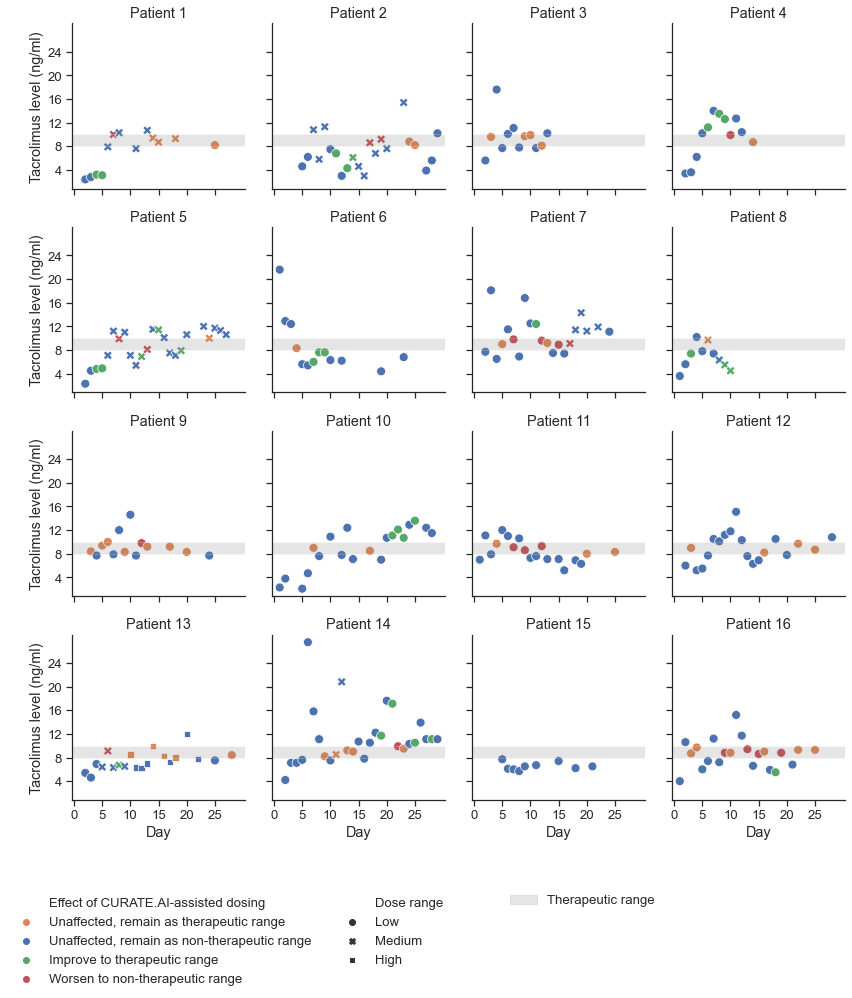

In [2]:
df = plot_effect_of_CURATE()
df

In [ ]:
# Generate plot for effect of CURATE



In [ ]:
%%time
# ~5mins

# Execute CURATE without pop tau
execute_CURATE(pop_tau_string='_by_body_weight_2')

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

In [ ]:
file_string='all_data_including_non_ideal.xlsx'
plot=True

# Plot individual profiles
dat = pd.read_excel(file_string, sheet_name='clean')

# Create within-range column for color
dat['within_range'] = (dat.response <= 10) & (dat.response >= 8)

# Create low/med/high dose column
dat['dose_range'] = ""
for i in range(len(dat)):
    if dat.dose[i] < 2:
        dat.loc[i, 'dose_range'] = 'Low'
    elif dat.dose[i] < 4:
        dat.loc[i, 'dose_range'] = 'Medium'
    else:
        dat.loc[i, 'dose_range'] = 'High'

# Rename columns and entries
new_dat = dat.copy()
new_dat = new_dat.rename(columns={'within_range':'Tacrolimus Levels'})
new_dat['Tacrolimus Levels'] = new_dat['Tacrolimus Levels'].map({True:'Therapeutic Range', False: 'Non-therapeutic Range'})
new_dat = new_dat.rename(columns={'dose_range':'Dose range', 'day':'Day'})
new_dat['patient'] = new_dat['patient'].map({84:1, 114:2, 117:3, 118:4, 120:5, 121:6, 122:7,
                                            123:8, 125:9, 126:10, 129:11, 130:12, 131:13, 132:14,
                                            133:15, 138:16})

if plot == True:

    # Plot dose vs response
    sns.set(font_scale=1.2, rc={"figure.figsize": (16,10), "xtick.bottom" : True, "ytick.left" : True}, style='white')

    plot = plt.scatter(new_dat.dose, new_dat.response, c=new_dat.Day, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.clf()
    cbar = plt.colorbar(plot)
    cbar.ax.tick_params(labelsize=20) 

    plt.savefig('colorbar.png', dpi=500, facecolor='w', bbox_inches='tight')

#     g = sns.relplot(data=new_dat, x='dose', y='response', hue='Day', col='patient', col_wrap=4, style='Dose range',
#             height=3, aspect=1,s=80)

#     # Add gray region for therapeutic range
#     for ax in g.axes:
#         ax.axhspan(8, 10, facecolor='grey', alpha=0.2)
        
#     g.set_titles('Patient {col_name}')
#     g.set_ylabels('Tacrolimus level (ng/ml)')
#     g.set_xlabels('Dose')
#     g.set(yticks=np.arange(0,math.ceil(max(new_dat.response)),4),
#         xticks=np.arange(0, max(new_dat.dose+1), step=1))

#     plt.savefig('indiv_pt_profile_by_dose.png', dpi=500, facecolor='w', bbox_inches='tight')

In [ ]:
df = effect_of_CURATE_RW()

In [ ]:
dat = df.copy()

In [ ]:
df = effect_of_CURATE_RW()

In [ ]:
dat = df.copy()

# Keep within_range only
dat_SOC_within_range = dat[dat.within_range==True].reset_index(drop=True)

# Find first day to achieve therapeutic range in SOC
SOC = dat_SOC_within_range.groupby('patient')['Day'].first().to_frame()

SOC_achieve_TR_in_first_week = SOC <= 7

# Keep those that are 1) unaffected by in TR and 2) improve to TR
dat_CURATE_within_range = dat[(dat['Effect of CURATE.AI-assisted dosing']=='Unaffected, remain as therapeutic range') |
                             (dat['Effect of CURATE.AI-assisted dosing']=='Improve to therapeutic range')].reset_index(drop=True)

# Find first day to achieve therapeutic range in CURATE
CURATE = dat_CURATE_within_range.groupby('patient')['Day'].first().to_frame()

CURATE_achieve_TR_in_first_week = CURATE <= 7

# Create dataframe with vales
plot_data = pd.Series({'Standard of care\ndosing': SOC_achieve_TR_in_first_week.sum()[0], 'CURATE.AI-assisted\ndosing':CURATE_achieve_TR_in_first_week.sum()[0]}).to_frame().reset_index()
plot_data.columns = ['Dosing', 'Patients that achieved therapeutic range in first week']

sns.set(font_scale=1.2, rc={"figure.figsize": (4,5), "xtick.bottom":True, "ytick.left":True}, style='white')
fig, ax = plt.subplots()
ax.bar(plot_data['Dosing'], plot_data['Patients that achieved therapeutic range in first week'], width=0.5, color=['y', 'm'])
sns.despine()
plt.ylabel('Patients that achieved\ntherapeutic range in first week')

# CURATE_achieve_TR_in_first_week.sum()[0]

# combined = SOC.merge(CURATE, how='left', on='patient')
# combined.columns=['SOC', 'CURATE']

# combined = combined.stack().to_frame().reset_index()
# combined.columns = ['patient', 'Dosing', 'Days to first therapeutic range']
# combined['Dosing'] = combined['Dosing'].replace({'SOC':'Standard of care', 'CURATE':'CURATE.AI-assisted'})

# sns.set(font_scale=1.2, rc={"figure.figsize": (5,5), "xtick.bottom":True, "ytick.left":True}, style='white')
# g = sns.boxplot(x="Dosing", y="Days to first therapeutic range", data=combined, width=0.5, palette=['#ccb974','#8172b3'])
# sns.despine()